In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import umap

from typing import Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

plt.rcParams['figure.figsize'] = [14, 3]

In [2]:
# загружаем датасет
data = pd.read_csv('data/raw/Weather.csv')
print(f'dataset shape: {data.shape}')
data.head(7)

dataset shape: (26271, 10)


,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,10000,Seoul,2016-01-01,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
1,11000,Busan,2016-01-01,5.3,1.1,10.9,0.0,7.4,340.0,52.1
2,12000,Daegu,2016-01-01,1.7,-4.0,8.0,0.0,3.7,270.0,70.5
3,13000,Gwangju,2016-01-01,3.2,-1.5,8.1,0.0,2.7,230.0,73.1
4,14000,Incheon,2016-01-01,3.1,-0.4,5.7,0.0,5.3,180.0,83.9
5,15000,Daejeon,2016-01-01,1.6,-4.2,7.7,0.0,4.4,320.0,77.4
6,16000,Ulsan,2016-01-01,4.0,-1.6,12.0,0.0,2.7,320.0,53.3


In [3]:
data = data[data['province'] == 'Seoul']
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index(['date']).sort_index()
data.fillna(method='ffill')
data.head()

,code,province,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
date,,,,,,,,,
2016-01-01,10000,Seoul,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
2016-01-02,10000,Seoul,5.7,1.0,9.5,0.0,4.5,320.0,76.9
2016-01-03,10000,Seoul,6.5,5.1,9.4,0.0,4.0,320.0,80.6
2016-01-04,10000,Seoul,2.0,-2.5,5.3,0.0,5.1,320.0,54.4
2016-01-05,10000,Seoul,-2.7,-4.8,1.5,0.0,4.6,20.0,39.4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642 entries, 2016-01-01 to 2020-06-29
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code                   1642 non-null   int64  
 1   province               1642 non-null   object 
 2   avg_temp               1642 non-null   float64
 3   min_temp               1642 non-null   float64
 4   max_temp               1641 non-null   float64
 5   precipitation          1642 non-null   float64
 6   max_wind_speed         1640 non-null   float64
 7   most_wind_direction    1639 non-null   float64
 8   avg_relative_humidity  1642 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 128.3+ KB


<AxesSubplot:xlabel='date'>

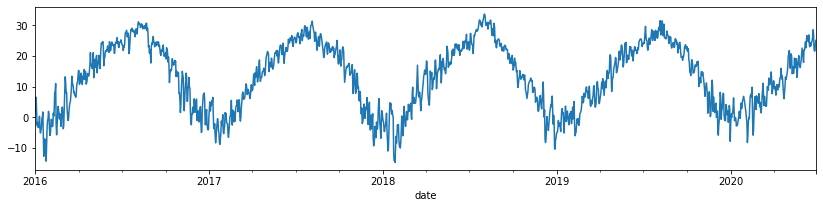

In [5]:
# наш признак
data['avg_temp'].plot()

<AxesSubplot:>

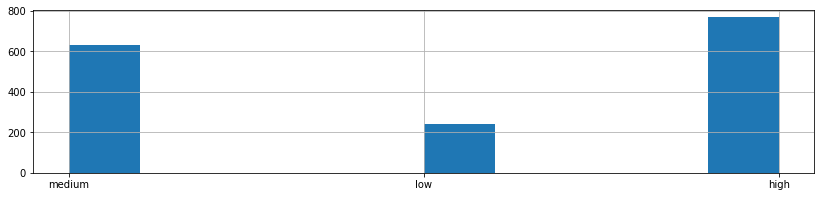

In [6]:
# дискретизируем его
data['avg_temp_n'] = data['avg_temp'].apply(lambda x: 'high' if x > 15 else 'medium' if x > 0 else 'low')
data['avg_temp_n'].hist()

In [7]:
# выбираем нужные нам признаки
x_features = ['avg_relative_humidity', 'precipitation', 'max_wind_speed', 'most_wind_direction']
y_feature  = 'avg_temp_n'

<AxesSubplot:>

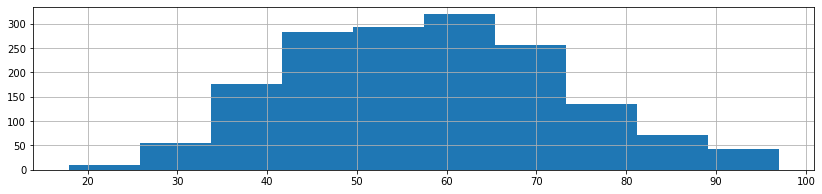

In [8]:
(data['avg_relative_humidity']).hist()

In [81]:
stats.normaltest(data['avg_relative_humidity'].sample(100))

NormaltestResult(statistic=0.23825470244061997, pvalue=0.8876947445541982)

In [104]:
print(stats.normaltest(data['precipitation'].sample(100)))
print(stats.normaltest(data['max_wind_speed'].sample(100)))
print(stats.normaltest(data['most_wind_direction'].sample(100)))
print(stats.normaltest(data['avg_temp'].sample(100)))

NormaltestResult(statistic=171.65690210117444, pvalue=5.311012437028955e-38)
NormaltestResult(statistic=2.1440545808495846, pvalue=0.34231384392610176)
NormaltestResult(statistic=19.743731339298655, pvalue=5.160635832841064e-05)
NormaltestResult(statistic=26.576045118259984, pvalue=1.6946699444520489e-06)


In [9]:
# введем значение ошибки - разница теоретического и практического количества
# особей в классе относительно теоретической величины самого класса
def get_err(pred: list, trueth: list) -> np.ndarray:
    uniqueT, countsT = np.unique(trueth, return_counts=True)
    uniqueP, countsP = np.unique(pred, return_counts=True)
    err = 0
    for i in range(len(countsT)):
        err = err + abs(countsP[i] - countsT[i]) / countsT[i]
    return err

In [10]:
# запустим модель и сравним предсказанные данные с тренировочной выборкой

# разделим выборку на тренировочную и тестовую
train, test = train_test_split(data, 
                               shuffle=True,
                               test_size=0.2, 
                               random_state=0)

def make_xy(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    x = data[x_features].fillna(method='ffill')
    y = data[y_feature]
    return x, y

# Обучим модель
x_train, y_train = make_xy(train)
trained_model = RandomForestClassifier().fit(x_train, y_train)

# Предскажем тестовые данные
x_test, y_test = make_xy(test)
y_pred = trained_model.predict(x_test)

0.31313155731760384


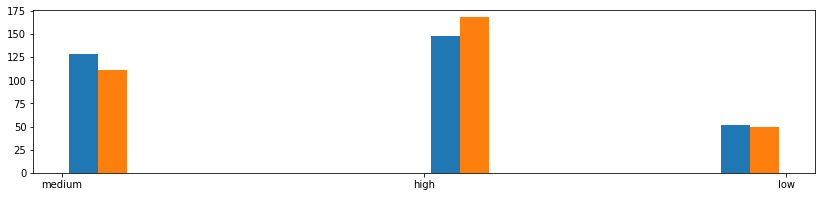

In [11]:
print(get_err(y_pred, y_test))

plt.hist([y_test, y_pred])
plt.show()

Вывод: ошибка мала, значит качесто предсказания довольно высокое